In [11]:
import graspy

import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from graspy.simulations import rdpg
from numpy import linalg as LA
from graspy.inference import LatentPositionTest
from graspy.plot import heatmap, pairplot

from graspy.embed import OmnibusEmbed, select_dimension, AdjacencySpectralEmbed, MultipleASE

%matplotlib inline

from graspy.simulations import sbm

def estimate_error(Phat, P):
    L_num = LA.norm(Phat-P, ord = 'fro')
    L_den = LA.norm(P, ord = 'fro')
    L = L_num/L_den
    return L


step = 0.25

error_MASE = []
error_OMNI = []

for j in range(11):

    n_vertex = 256

    n = [128, 128]

    number_graphs = 40 #10 for each class(4 classes)

    #two blocks

    alpha = step*j

    C1 = np.identity(2)*0.1
    C2 = -C1
    C3 = np.array([[0.1, 0],
                [0, 0]])
    C4 = np.array([[0, 0],
                [0, 0.1]])



    B1 = 0.25*(np.ones((2,1))@np.ones((1,2))) + alpha*C1
    B2 = 0.25*(np.ones((2,1))@np.ones((1,2))) + alpha*C2
    B3 = 0.25*(np.ones((2,1))@np.ones((1,2))) + alpha*C3
    B4 = 0.25*(np.ones((2,1))@np.ones((1,2))) + alpha*C4

    np.random.seed(1)
    G = []
    for i in range(10):
        g = sbm(n=n, p=B1)
        G.append(g)
    for i in range(10,20):
        g = sbm(n=n, p=B2)
        G.append(g)
    for i in range(20,30):
        g = sbm(n=n, p=B3)
        G.append(g)
    for i in range(30,40):
        g = sbm(n=n, p=B4)
        G.append(g)
    embedder = MultipleASE()
    V = embedder.fit_transform(G)

    OMNI_embedder = OmnibusEmbed()
    Zhat = OMNI_embedder.fit_transform(G)

    print(V.shape)
    print(Zhat.shape)

    z_community1 = np.array([1,0])
    z_community1 = np.broadcast_to(z_community1, (128, 2))

    z_community2 = np.array([0, 1])
    z_community2 = np.broadcast_to(z_community2, (128, 2))

    Z = np.concatenate((z_community1, z_community2), axis=0)

    R = embedder.scores_

    Phat_MASE=[]
    Phat_OMNI = []

    for i in range(number_graphs):
        phat_M = V @ R[i] @ V.T
        Phat_MASE.append(phat_M)

        phat_O = Zhat[i] @ Zhat[i].T
        Phat_OMNI.append(phat_O)


    sum_error_MASE = 0
    for i in range(number_graphs):
        if(i < 10):
            sum_error_MASE = sum_error_MASE + estimate_error(Phat_MASE[i],Z @ B1 @ Z.T)
        elif((i >= 10) and (i < 20)):
            sum_error_MASE = sum_error_MASE + estimate_error(Phat_MASE[i],Z @ B2 @ Z.T)
        elif((i >= 20) and (i < 30)):
            sum_error_MASE = sum_error_MASE + estimate_error(Phat_MASE[i],Z @ B3 @ Z.T)
        elif((i >= 30) and (i < 40)):
            sum_error_MASE = sum_error_MASE + estimate_error(Phat_MASE[i],Z @ B4 @ Z.T)

    sum_error_OMNI = 0
    for i in range(number_graphs):
        if(i < 10):
            sum_error_OMNI = sum_error_OMNI + estimate_error(Phat_OMNI[i],Z @ B1 @ Z.T)
        elif((i >= 10) and (i < 20)):
            sum_error_OMNI = sum_error_OMNI + estimate_error(Phat_OMNI[i],Z @ B2 @ Z.T)
        elif((i >= 20) and (i < 30)):
            sum_error_OMNI = sum_error_OMNI + estimate_error(Phat_OMNI[i],Z @ B3 @ Z.T)
        elif((i >= 30) and (i < 40)):
            sum_error_OMNI = sum_error_OMNI + estimate_error(Phat_OMNI[i],Z @ B4 @ Z.T)

    avg_error_OMNI = sum_error_OMNI/number_graphs
    avg_error_MASE = sum_error_MASE/number_graphs

    print(avg_error_MASE)
    print(avg_error_OMNI)

    error_MASE.append(avg_error_MASE)
    error_OMNI.append(avg_error_OMNI)


(256, 4)
(40, 256, 7)
0.046197434226161606
0.19744807377489984
(256, 4)
(40, 256, 8)
0.06659335944974573
0.212594543904628
(256, 2)
(40, 256, 2)
0.06174760420092569
0.11738905702713227
(256, 2)
(40, 256, 2)
0.046347710461017835
0.12496788009002428
(256, 2)
(40, 256, 2)
0.04157299733889299
0.1396359706966585
(256, 2)
(40, 256, 2)
0.03968514835808352
0.15636661452917397
(256, 2)
(40, 256, 2)
0.03943077295659487
0.174516284181847
(256, 2)
(40, 256, 2)
0.03849368671129438
0.19351511325141602
(256, 4)
(40, 256, 2)
0.049034465898759545
0.21303129751422176
(256, 5)
(40, 256, 2)
0.05279790206464924
0.23243690012017054
(256, 6)
(40, 256, 2)
0.055527162960613476
0.2507286130896683


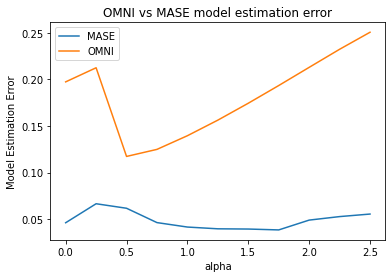

In [15]:
import matplotlib.pyplot as plt
alpha = []
for i in range(len(error_OMNI)):
    alpha.append(step*i)

ax = plt.subplot(111)
ax.plot(alpha, error_MASE, label='MASE')
ax.plot(alpha, error_OMNI, label='OMNI')
plt.xlabel("alpha")
plt.ylabel("Model Estimation Error")
plt.title('OMNI vs MASE model estimation error')

ax.legend()